In [1]:
import torch

pim = (3, 3)

x = torch.randint(0, 16, (1, 10))
w = torch.randint(0, 10, (10, 1))
print(x.flatten())
print(w.flatten())

y = torch.matmul(x, w)
print(y)

print(y.abs())


tensor([ 0, 14,  5, 10,  0,  7,  2,  0, 10,  6])
tensor([2, 1, 6, 7, 4, 0, 7, 8, 9, 5])
tensor([[248]])
tensor([[248]])


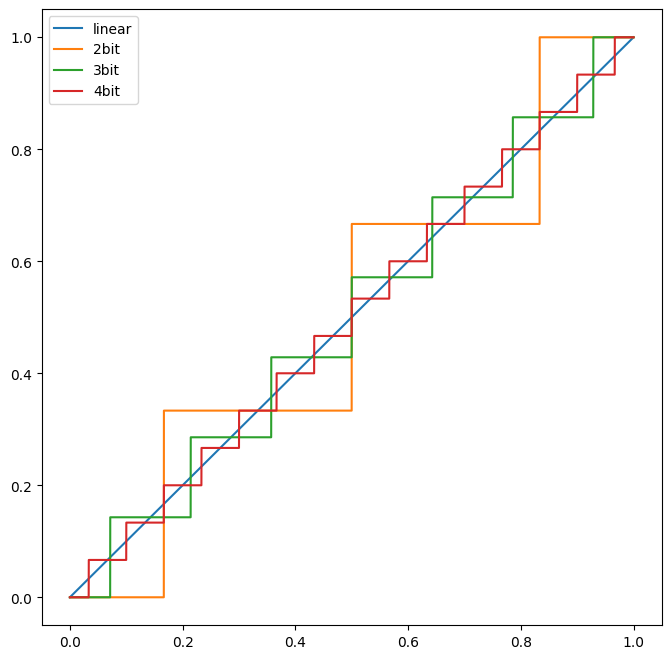

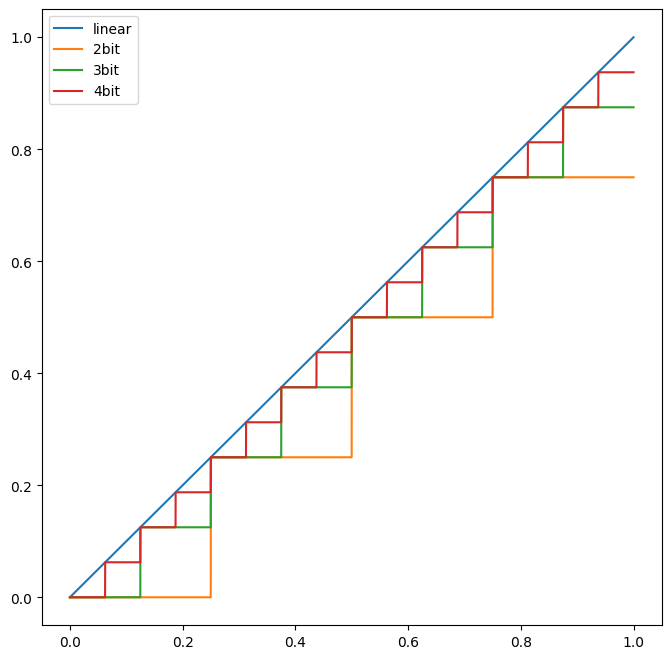

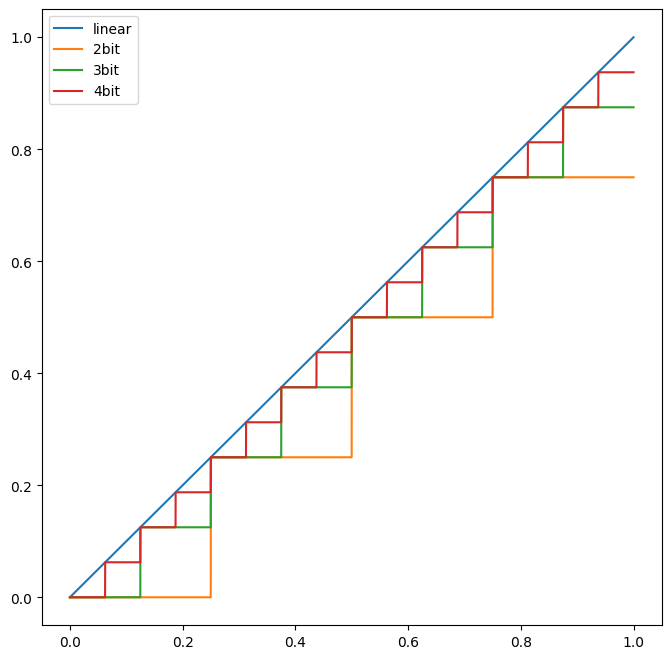

In [2]:
import matplotlib.pyplot as plt
import math

bit = 3

def quant(x, bit=bit):
    step = 2**bit - 1.
    return (1/step) * torch.round(step * x)

def pact(x, a=1):
    return 0.5 * (x.abs() - (x-a).abs() + a)

def sat(x, bit=bit):
    step = torch.empty(x.size()).fill_(2**bit)
    return (1/step) * torch.minimum(torch.floor(step * x), step-1.)

def neurosim(x, bit):
    minQ = torch.min(x)
    delta = torch.max(x) - torch.min(x)
    y = x.clone()

    stepSizeRatio = 2.**(-bit)
    stepSize = stepSizeRatio*delta.item()
    index = torch.clamp(torch.floor((x-minQ.item())/stepSize), 0, (2.**(bit)-1))
    y = index*stepSize + minQ.item()

    return y

x1 = torch.arange(0, 10001, step=1) / 10000

ptq = plt.figure(figsize=(8,8))
p = pact(x1).flatten()
q2 = quant(x1, bit=2)
q3 = quant(x1, bit=3)
q4 = quant(x1, bit=4)
n1 = neurosim(x1, bit=4)
plt.plot(x1, p, label="linear")
plt.plot(x1, q2, label="2bit")
plt.plot(x1, q3, label="3bit")
plt.plot(x1, q4, label="4bit")
plt.legend()

ptq = plt.figure(figsize=(8,8))
p = pact(x1).flatten()
q2 = sat(x1, bit=2)
q3 = sat(x1, bit=3)
q4 = sat(x1, bit=4)
plt.plot(x1, p, label="linear")
plt.plot(x1, q2, label="2bit")
plt.plot(x1, q3, label="3bit")
plt.plot(x1, q4, label="4bit")
plt.legend()

ptq = plt.figure(figsize=(8,8))
p = pact(x1).flatten()
q2 = neurosim(x1, bit=2)
q3 = neurosim(x1, bit=3)
q4 = neurosim(x1, bit=4)
plt.plot(x1, p, label="linear")
plt.plot(x1, q2, label="2bit")
plt.plot(x1, q3, label="3bit")
plt.plot(x1, q4, label="4bit")
plt.legend()
# plt.show()


In [3]:
x1 = 27
x2 = -1

t1 = format(x1, '08b')
t2 = format(x2 & 0xff, '08b')

print(t1[:4], t1[4:])
print(t2[:4], t2[4:])


0001 1011
1111 1111


base:  8 tensor([0., 1., 2., 3., 4., 5., 6., 7.])
base + max_min_norm:  8 tensor([0., 1., 2., 3., 4., 5., 6., 7.])
sat:  8 tensor([0., 1., 2., 3., 4., 5., 6., 7.])
sat + max_min_norm:  8 tensor([0., 1., 2., 3., 4., 5., 6., 7.])


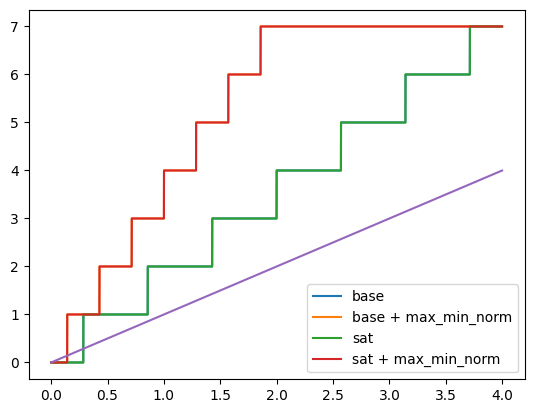

In [4]:
def LinearQuantizeN(x, bit, max_val, min_val=0., scale=True):
    stepSize = 2.**(bit) - 1
    x = torch.clamp(x, min_val, max_val)
    x = x / (x.max() - x.min())
    
    if scale:
        return torch.round(stepSize * x) / stepSize * max_val, stepSize, min_val
    else:
        return torch.round(stepSize * x), stepSize, min_val

# max value depends on # of rows in PIM array
def LinearQuantizeSAT(x, bit, max_vol, min_val=0., scale=True):
    delta = max_vol - min_val

    stepSizeRatio = 2.**(-bit)
    stepSize = stepSizeRatio * delta
    index = torch.clamp(torch.floor((x-min_val)/stepSize), 0, (2.**(bit)-1))
    if scale:
        return index*stepSize + min_val, stepSize, min_val
    else:
        return index, stepSize, min_val

def LinearQuantize(x, bit, scale=True, sat=False, max_min_norm=False):
    if max_min_norm:
        min_val = (x < 0.).float().mul(x).norm(1) / ((x < 0.).float().sum() + 1e-15)
        max_val = (x > 0.).float().mul(x).norm(1) / ((x > 0.).float().sum() + 1e-15)
    else:
        min_val = x.min()
        max_val = x.max()
    
    if sat:
        return LinearQuantizeSAT(x, bit, max_val, min_val, scale)
    else:
        return LinearQuantizeN(x, bit, max_val, min_val, scale)
    
bit=3
x = torch.arange(0, 4, step=0.001)
qx1,a,b = LinearQuantize(x, bit, scale=False, sat=False, max_min_norm=False)
qx2,a,b = LinearQuantize(x, bit, scale=False, sat=False, max_min_norm=True)
qx3,a,b = LinearQuantize(x, bit, scale=False, sat=True, max_min_norm=False)
qx4,a,b = LinearQuantize(x, bit, scale=False, sat=True, max_min_norm=True)

uniqs = torch.unique(qx1)
print("base: ", len(uniqs), uniqs)
uniqs = torch.unique(qx2)
print("base + max_min_norm: ", len(uniqs), uniqs)
uniqs = torch.unique(qx3)
print("sat: ", len(uniqs), uniqs)
uniqs = torch.unique(qx4)
print("sat + max_min_norm: ", len(uniqs), uniqs)

plt.plot(x, qx1.flatten(), label="base")
plt.plot(x, qx2.flatten(), label="base + max_min_norm")
plt.plot(x, qx1.flatten(), label="sat")
plt.plot(x, qx2.flatten(), label="sat + max_min_norm")
plt.plot(x, x.flatten())
plt.legend()
plt.show()

base:  8 tensor([0.0000, 0.5713, 1.1426, 1.7139, 2.2851, 2.8564, 3.4277, 3.9990])
base:  8 tensor([0.0000, 0.5713, 1.1426, 1.7139, 2.2851, 2.8564, 3.4277, 3.9990])
base + max_min_norm:  8 tensor([0.0000, 0.5713, 1.1426, 1.7139, 2.2851, 2.8564, 3.4277, 3.9990])


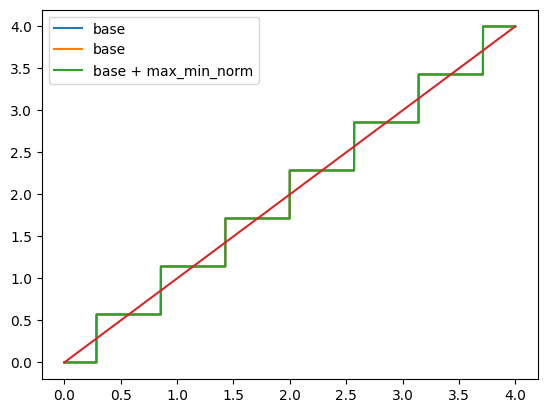

In [14]:
import torch.nn.functional as F

def LinearQuantizeIN1(x, k, alpha):                # only quantize >0 values (relu must be preceded)
    L = 2.**k - 1
    xdiv = x.div(alpha)
    xc = xdiv.clamp(min=0., max=1.)
    xq = xc.mul(L).round()
    xmul = xq.div(L).mul(alpha)
    return xq, xmul, alpha

def LinearQuantizeIN(x, k, alpha):                  # due to skip connection, minus value exists, therefore, use this (quantize <0 values as well)
    L = 2.**k - 1
    step_size = alpha / L
    output = F.hardtanh(x, min_val=-alpha, max_val=alpha)
    output = torch.round(output / step_size)
    
    return output, output * step_size, alpha

def LinearQuantizeW(x, k, max_val, min_val):        # asymetric quant
    delta = max_val - min_val
    L= 2 ** k - 1
    stepSize = delta
    index = torch.clamp(torch.round((x-min_val)/stepSize * L), 0, L)
    return index, index*stepSize/L + min_val, delta
    
bit=3
x = torch.arange(0.00, 4.00, step=0.001)
qx0,a0,b = LinearQuantizeIN1(x, bit, x.max())
qx1,a1,b = LinearQuantizeIN(x, bit, x.max())
qx2,a2,b = LinearQuantizeW(x, bit, x.max(), x.min())

uniqs = torch.unique(a0)
print("base: ", len(uniqs), uniqs)
uniqs = torch.unique(a1)
print("base: ", len(uniqs), uniqs)
uniqs = torch.unique(a2)
print("base + max_min_norm: ", len(uniqs), uniqs)

plt.plot(x, a0.flatten(), label="base")
plt.plot(x, a1.flatten(), label="base")
plt.plot(x, a2.flatten(), label="base + max_min_norm")
plt.plot(x, x.flatten())
plt.legend()
plt.show()

base:  8 tensor([0., 1., 2., 3., 4., 5., 6., 7.])
base:  8 tensor([-4.0000e+00, -3.0001e+00, -2.0002e+00, -1.0004e+00, -4.9996e-04,
         9.9937e-01,  1.9992e+00,  2.9991e+00])
base:  8 tensor([0., 1., 2., 3., 4., 5., 6., 7.])
base:  8 tensor([0.0000, 0.5713, 1.1426, 1.7139, 2.2851, 2.8564, 3.4277, 3.9990])


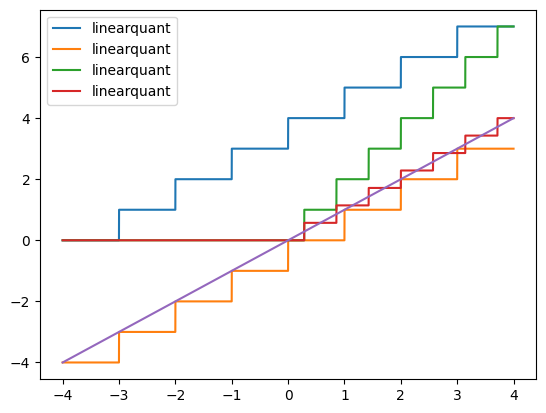

In [6]:

def LinearQuantizeIN(x, k, alpha):
    L = 2.**k - 1
    xdiv = x.div(alpha)
    xc = xdiv.clamp(min=0., max=1.)
    xq = xc.mul(L).round()
    xmul = xq.div(L).mul(alpha)
    
    return xq, xmul

def LinearQuantizeW(x, k, max_val, min_val):
    delta = max_val - min_val

    stepSizeRatio = 2.**(-k)
    stepSize = stepSizeRatio * delta
    index = torch.clamp(torch.floor((x-min_val)/stepSize), 0, (2.**(k)-1))
    return index, index*stepSize + min_val

# # max value depends on # of rows in PIM array
# def LinearQuantizeSAT(x, k, max_vol, min_val=0., scale=True):
#     delta = max_vol - min_val

#     stepSizeRatio = 2.**(-k)
#     stepSize = stepSizeRatio * delta
#     index = torch.clamp(torch.floor((x-min_val)/stepSize), 0, (2.**(k)-1))
#     if scale:
#         return index*stepSize + min_val, stepSize, min_val
#     else:
#         return index, stepSize, min_val

# def LinearQuantize(x, k, scale=True, sat=False, max_min_norm=False):
#     if max_min_norm:
#         min_val = (x < 0.).float().mul(x).norm(1) / ((x < 0.).float().sum() + 1e-15)
#         max_val = (x > 0.).float().mul(x).norm(1) / ((x > 0.).float().sum() + 1e-15)
#     else:
#         min_val = x.min()
#         max_val = x.max()
    
#     if sat:
#         return LinearQuantizeSAT(x, k, max_val, min_val, scale)
#     else:
#         return LinearQuantizeIN(x, k, max_val, min_val, scale)
    
k=3
x = torch.arange(-4, 4, step=0.001)
qx1,qx2 = LinearQuantizeW(x, k, x.max(), x.min())
qx3,qx4 = LinearQuantizeIN(x, k, x.max())

uniqs = torch.unique(qx1)
print("base: ", len(uniqs), uniqs)
uniqs = torch.unique(qx2)
print("base: ", len(uniqs), uniqs)
uniqs = torch.unique(qx3)
print("base: ", len(uniqs), uniqs)
uniqs = torch.unique(qx4)
print("base: ", len(uniqs), uniqs)

plt.plot(x, qx1.flatten(), label="linearquant")
plt.plot(x, qx2.flatten(), label="linearquant")
plt.plot(x, qx3.flatten(), label="linearquant")
plt.plot(x, qx4.flatten(), label="linearquant")

plt.plot(x, x.flatten())
plt.legend()
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def LinearQuantizeIN(x, k, alpha):
    L = 2.**k - 1
    xdiv = x.div(alpha)
    xc = xdiv.clamp(min=0., max=1.)
    xq = xc.mul(L).round()
    xmul = xq.div(L).mul(alpha)
    
    return xq, xmul, alpha

def LinearQuantizeW(x, k, max_val, min_val):
    delta = max_val - min_val

    stepSizeRatio = 2.**(-k)
    stepSize = stepSizeRatio * delta
    index = torch.clamp(torch.floor((x-min_val)/stepSize), 0, (2.**(k)-1))
    return index, index*stepSize + min_val, delta

# # max value depends on # of rows in PIM array
# def LinearQuantizeSAT(x, bit, max_vol, min_val=0., scale=True):
#     delta = max_vol - min_val

#     stepSizeRatio = 2.**(-bit)
#     stepSize = stepSizeRatio * delta
#     index = torch.clamp(torch.floor((x-min_val)/stepSize), 0, (2.**(bit)-1))
#     if scale:
#         return index*stepSize + min_val
#     else:
#         return index, stepSize, min_val

class QLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=False,wl_input=8,wl_weight= 8,inference=0,cellBit=1,subArray=128,ADCprecision=5):
        super(QLinear, self).__init__(in_features, out_features, bias)
        self.wl_weight = wl_weight
        self.wl_input = wl_input
        self.inference = inference
        self.cellBit = cellBit
        self.subArray = subArray
        self.ADCprecision = ADCprecision

    def forward(self, input):
        outputOrignal = F.linear(input, self.weight, self.bias)
        bitWeight = int(self.wl_weight)
        bitActivation = int(self.wl_input)

        if self.inference == 1:
            # set parameters for Hardware Inference
            output = torch.zeros_like(outputOrignal)
            cellRange = 2 # 2**self.cellBit   # due to SRAM, it has only 2 cellRange
            # need to divide to different subArray
            numSubArray = int(self.weight.shape[1]/self.subArray)

            if numSubArray == 0:
                mask = torch.zeros_like(self.weight)
                mask[:,:] = 1
                # quantize input into binary sequence
                inputQ, _, inputS = LinearQuantizeIN(input, self.wl_input, input.max())
                outputIN = torch.zeros_like(outputOrignal)
                for z in range(bitActivation):
                    inputB = torch.fmod(inputQ, 2)              # 12,10,14 = [0,0,0] / [0,1,1] / [1,0,1] / [1,1,1]
                    inputQ = torch.round((inputQ-inputB)/2)     # 12,10,14 = [6,5,7] / [3,2,3] / [1,1,1] / [0,0,0]
                    # after get the spacial kernel, need to transfer floating weight [-1, 1] to binarized ones
                    weightQ, _, weightS = LinearQuantizeW(self.weight, self.wl_weight, self.weight.max(), self.weight.min())      # [-1,1] -> [0,2] -> [0,1] by mod 2 -> (2^k-1) * weight [0,1] -> -1~1 mapped to 0~2^k-1
                    outputP = torch.zeros_like(outputOrignal)
                    for k in range (int(bitWeight/self.cellBit)):
                        weightB = torch.fmod(weightQ, cellRange)
                        weightQ = torch.round((weightQ-weightB)/cellRange)
                        # noise variation
                        # variation = np.random.normal(0, self.vari, list(weightQ.size())).astype(np.float32)
                        # weightQ = torch.round((weightQ-remainder)/cellRange)
                        outputPartial = F.linear(inputB, weightB, self.bias)
                        # Add ADC quanization effects here !!!
                        _, outputADC = LinearQuantizeIN(outputPartial, self.ADCprecision, self.subArray)
                        # shift per weight bit sequence
                        outputP = outputP + outputADC * (cellRange ** k)
                    # shift per input bit sequence
                    outputIN = outputIN + outputP * (2 ** z)
                # since inputQ [0, 15] when k=4, rescale output by divide 16
                output = output + outputIN / (2 ** bitActivation) * inputS * weightS
            else:
                inputQ, _, inputS = LinearQuantizeIN(input, self.wl_input, input.max())
                outputIN = torch.zeros_like(outputOrignal)
                for z in range(bitActivation):
                    inputB = torch.fmod(inputQ, 2)
                    inputQ = torch.round((inputQ-inputB)/2)
                    outputPmerge = torch.zeros_like(outputOrignal)
                    for s in range(numSubArray):
                        # only convoled weight is 1, otherwise 0
                        mask = torch.zeros_like(self.weight)
                        mask[:,(s*self.subArray):(s+1)*self.subArray] = 1
                        # after get the spacial kernel, need to transfer floating weight [-1, 1] to binarized ones
                        weightQ, _, weightS = LinearQuantizeW(self.weight*mask, self.wl_weight, self.weight.max(), self.weight.min())
                        outputP = torch.zeros_like(outputOrignal)
                        for k in range (int(bitWeight/self.cellBit)):
                            weightB = torch.fmod(weightQ, cellRange)*mask
                            weightQ = torch.round((weightQ-weightB)/cellRange)*mask
                            # noise variation
                            # variation = np.random.normal(0, self.vari, list(weight.size())).astype(np.float32)
                            # weightQ = torch.round((weightQ-remainder)/cellRange)*mask
                            outputPartial= F.linear(inputB, weightB, self.bias)
                            # Add ADC quanization effects here !!!
                            _, outputADC = LinearQuantizeIN(outputPartial, self.ADCprecision, self.subArray)
                            # shift per weight bit sequence
                            outputP = outputP + outputADC * (cellRange ** k)
                        # merge sub array outputP
                        outputPmerge = outputPmerge + outputP
                    # shift per input bit sequence
                    outputIN = outputIN + outputP * (2 ** z)
                # since inputQ [0, 15] when k=4, rescale output by divide 16
                output = output + outputIN / (2 ** bitActivation) * inputS * weightS
                
            # since weightQ [0, 15] when k=4, rescale output by divide 16
            output = output / (2 ** bitWeight)
        else:
            # original WAGE QCov2d
            _, inputQS, inputS = LinearQuantizeIN(input, self.wl_input, input.max())
            _, weightQS, weightS = LinearQuantizeW(self.weight, self.wl_weight, self.weight.max(), self.weight.min())
            print(torch.unique(weightQS))
            print(len(torch.unique(weightQS)))
            output = F.linear(inputQS, weightQS, self.bias)
            print("original: ", outputOrignal)
        return output

In [8]:
x = torch.randint(0, 5, size=(1, 1000)).float()
w = (torch.rand(size=(1000,)) - 0.5) * 3.5

l = QLinear(10, 1)
l.weight.data = w
y = l(x)
print(y)



tensor([-1.7482e+00, -1.7345e+00, -1.7209e+00, -1.7072e+00, -1.6936e+00,
        -1.6799e+00, -1.6662e+00, -1.6526e+00, -1.6389e+00, -1.6253e+00,
        -1.6116e+00, -1.5980e+00, -1.5843e+00, -1.5707e+00, -1.5570e+00,
        -1.5434e+00, -1.5297e+00, -1.5161e+00, -1.5024e+00, -1.4888e+00,
        -1.4615e+00, -1.4478e+00, -1.4342e+00, -1.4205e+00, -1.4069e+00,
        -1.3932e+00, -1.3796e+00, -1.3659e+00, -1.3523e+00, -1.3386e+00,
        -1.3249e+00, -1.3113e+00, -1.2976e+00, -1.2840e+00, -1.2703e+00,
        -1.2567e+00, -1.2430e+00, -1.2294e+00, -1.2157e+00, -1.2021e+00,
        -1.1884e+00, -1.1748e+00, -1.1611e+00, -1.1475e+00, -1.1338e+00,
        -1.1202e+00, -1.1065e+00, -1.0929e+00, -1.0792e+00, -1.0656e+00,
        -1.0519e+00, -1.0383e+00, -1.0246e+00, -1.0110e+00, -9.9730e-01,
        -9.8365e-01, -9.7000e-01, -9.5635e-01, -9.4270e-01, -9.2904e-01,
        -9.1539e-01, -9.0174e-01, -8.8809e-01, -8.7444e-01, -8.6078e-01,
        -8.4713e-01, -8.3348e-01, -8.1983e-01, -8.0